## Configuracion del entorno y librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, 
                             roc_curve, f1_score, matthews_corrcoef, make_scorer)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist
import shap
import warnings

# Configuración Global
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(" Librerías cargadas para k-NN.")

 Librerías cargadas para k-NN.


## Carga y estandarizacion de datos

In [2]:
# 1. Cargar datasets
train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Training.csv")
test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_Test.csv")
ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR\EDA/FINAL_External.csv")
# 2. Definir Variables
target_col = 'Actividad'
features = [c for c in train.columns if c != target_col]

print(f"Variables ({len(features)}): {features}")

# 3. Codificación de Clase
le = LabelEncoder()
y_train = le.fit_transform(train[target_col])
y_test = le.transform(test[target_col])
y_ext = le.transform(ext[target_col])

# 4. Estandarización (CRUCIAL para k-NN)
# Ajustamos el escalador SOLO con el training para evitar fugas de información
scaler = StandardScaler()
X_train_np = scaler.fit_transform(train[features])
X_test_np = scaler.transform(test[features])
X_ext_np = scaler.transform(ext[features])

# Convertimos de nuevo a DataFrame para mantener nombres de columnas
X_train = pd.DataFrame(X_train_np, columns=features)
X_test = pd.DataFrame(X_test_np, columns=features)
X_ext = pd.DataFrame(X_ext_np, columns=features)

print(" Datos estandarizados correctamente (Media=0, Varianza=1).")

Variables (11): ['LOGPcons', 'MACCSFP125', 'PCR', 'Psi_e_A', 'P_VSA_ppp_D', 'Mp', 'SpMin1_Bh(p)', 'SHED_AL', 'SM12_AEA(ri)', 'P_VSA_s_3', 'MATS5m']
 Datos estandarizados correctamente (Media=0, Varianza=1).


## Tuning

In [3]:
print(" Iniciando Tuning de k-NN...")

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # La 'k'
    'weights': ['uniform', 'distance'],   # Ponderación
    'metric': ['euclidean', 'manhattan'], # Geometría
    'p': [1, 2]                           # Potencia Minkowski
}

knn = KNeighborsClassifier()

# Búsqueda optimizando AUC
grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=10, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_

print(f" Mejores parámetros k-NN: {grid_search.best_params_}")
print(f"Mejor AUC en CV: {grid_search.best_score_:.4f}")

 Iniciando Tuning de k-NN...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
 Mejores parámetros k-NN: {'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Mejor AUC en CV: 0.7783


## Evaluacion de metricas

In [4]:
def calcular_metricas(model, X, y, nombre_set):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    return {
        'Dataset': nombre_set,
        'Accuracy': accuracy_score(y, y_pred),
        'Sensibilidad (TP Rate)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Especificidad (TN Rate)': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'AUC-ROC': roc_auc_score(y, y_prob),
        'Kappa': (2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))),
        'MCC': matthews_corrcoef(y, y_pred),
        'F1-Score': f1_score(y, y_pred)
    }

# Calcular métricas
res_train = calcular_metricas(best_knn, X_train, y_train, 'Training')
res_test = calcular_metricas(best_knn, X_test, y_test, 'Test Interno')
res_ext = calcular_metricas(best_knn, X_ext, y_ext, 'Validación Externa')

# Mostrar Tabla
df_res = pd.DataFrame([res_train, res_test, res_ext]).set_index('Dataset')
print(" RESULTADOS k-NN:")
display(df_res.round(3))

 RESULTADOS k-NN:


,Accuracy,Sensibilidad (TP Rate),Especificidad (TN Rate),AUC-ROC,Kappa,MCC,F1-Score
Dataset,,,,,,,
Training,0.772,0.852,0.680,0.858,0.536,0.542,0.800
Test Interno,0.741,0.846,0.621,0.814,0.473,0.482,0.778
Validación Externa,0.881,0.950,0.163,0.607,0.133,0.136,0.936


## Visualizacion 

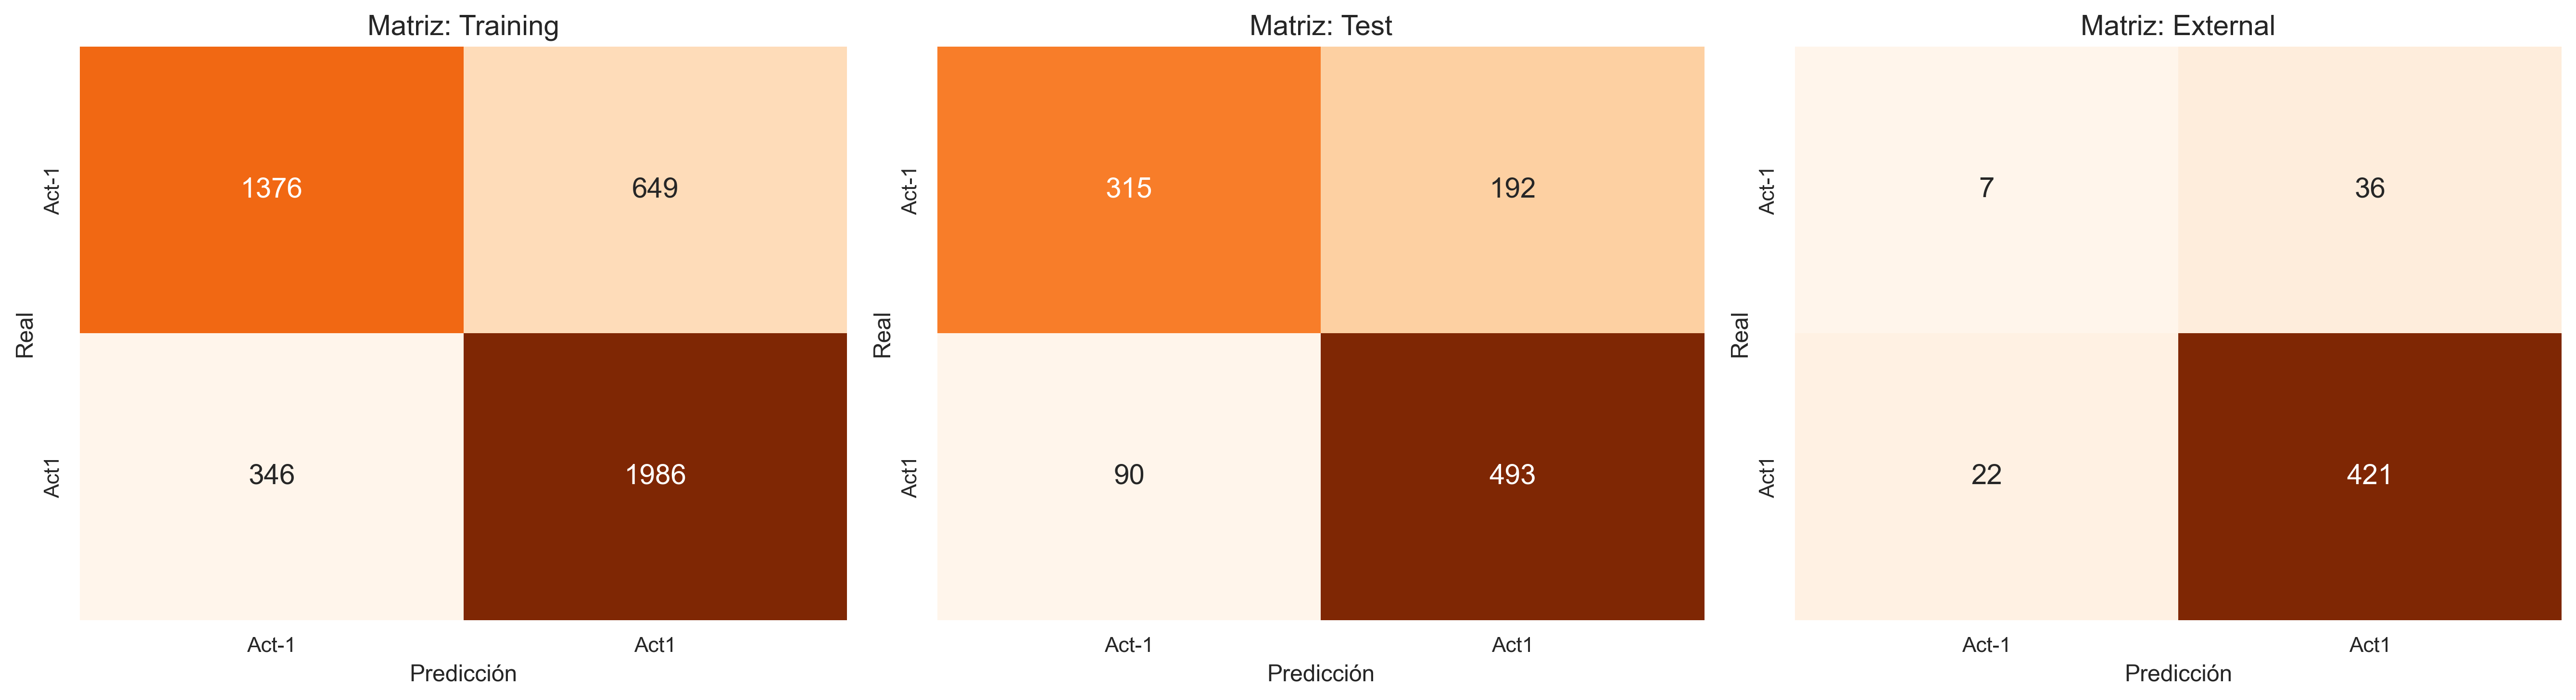

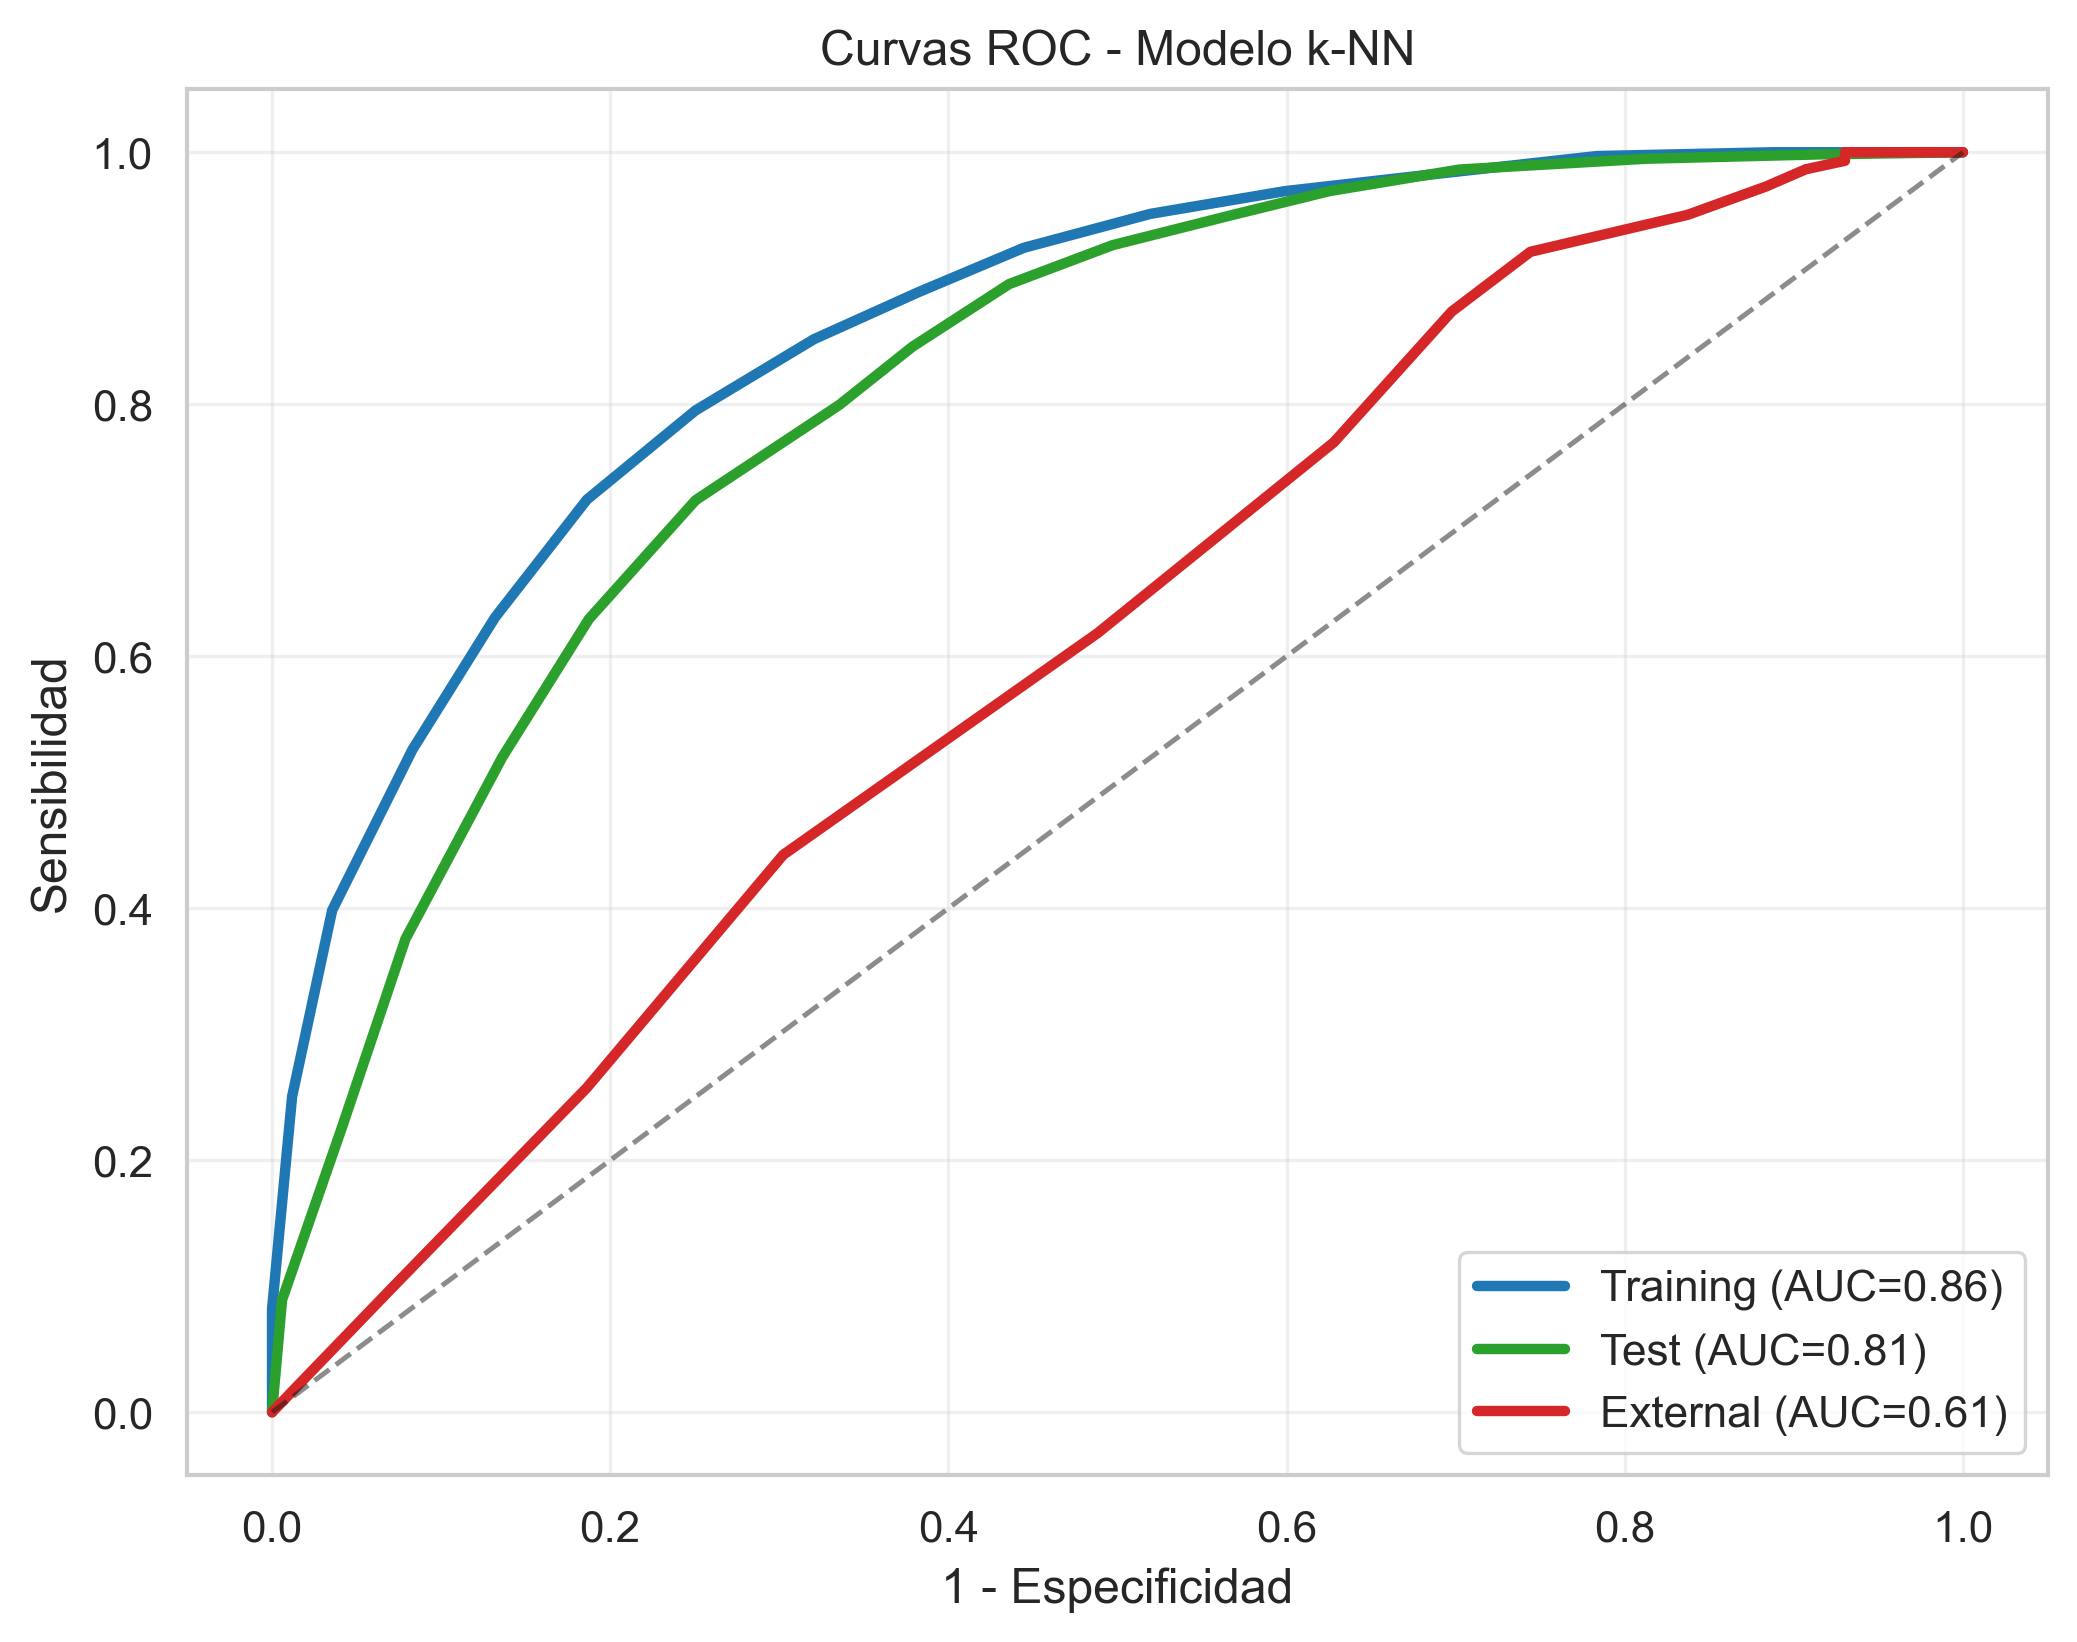

In [5]:
# A. MATRICES DE CONFUSIÓN
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sets = [(X_train, y_train, 'Training'), (X_test, y_test, 'Test'), (X_ext, y_ext, 'External')]

for i, (X_c, y_c, title) in enumerate(sets):
    cm = confusion_matrix(y_c, best_knn.predict(X_c))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[i], cbar=False,
                xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
    axes[i].set_title(f'Matriz: {title}', fontsize=14)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

# B. CURVAS ROC
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#2ca02c', '#d62728']

for (X_c, y_c, title), color in zip(sets, colors):
    y_prob = best_knn.predict_proba(X_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_c, y_prob)
    auc = roc_auc_score(y_c, y_prob)
    plt.plot(fpr, tpr, label=f'{title} (AUC={auc:.2f})', color=color, lw=2.5)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curvas ROC - Modelo k-NN')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Interpretabilidad

 Calculando SHAP para k-NN (Aproximación por Kernel)...
Calculando SHAP para 50 muestras...


  0%|          | 0/50 [00:00<?, ?it/s]

Formato detectado: Array con forma (50, 11, 2)
Forma de los datos X: (50, 11)
Forma de SHAP values: (50, 11)


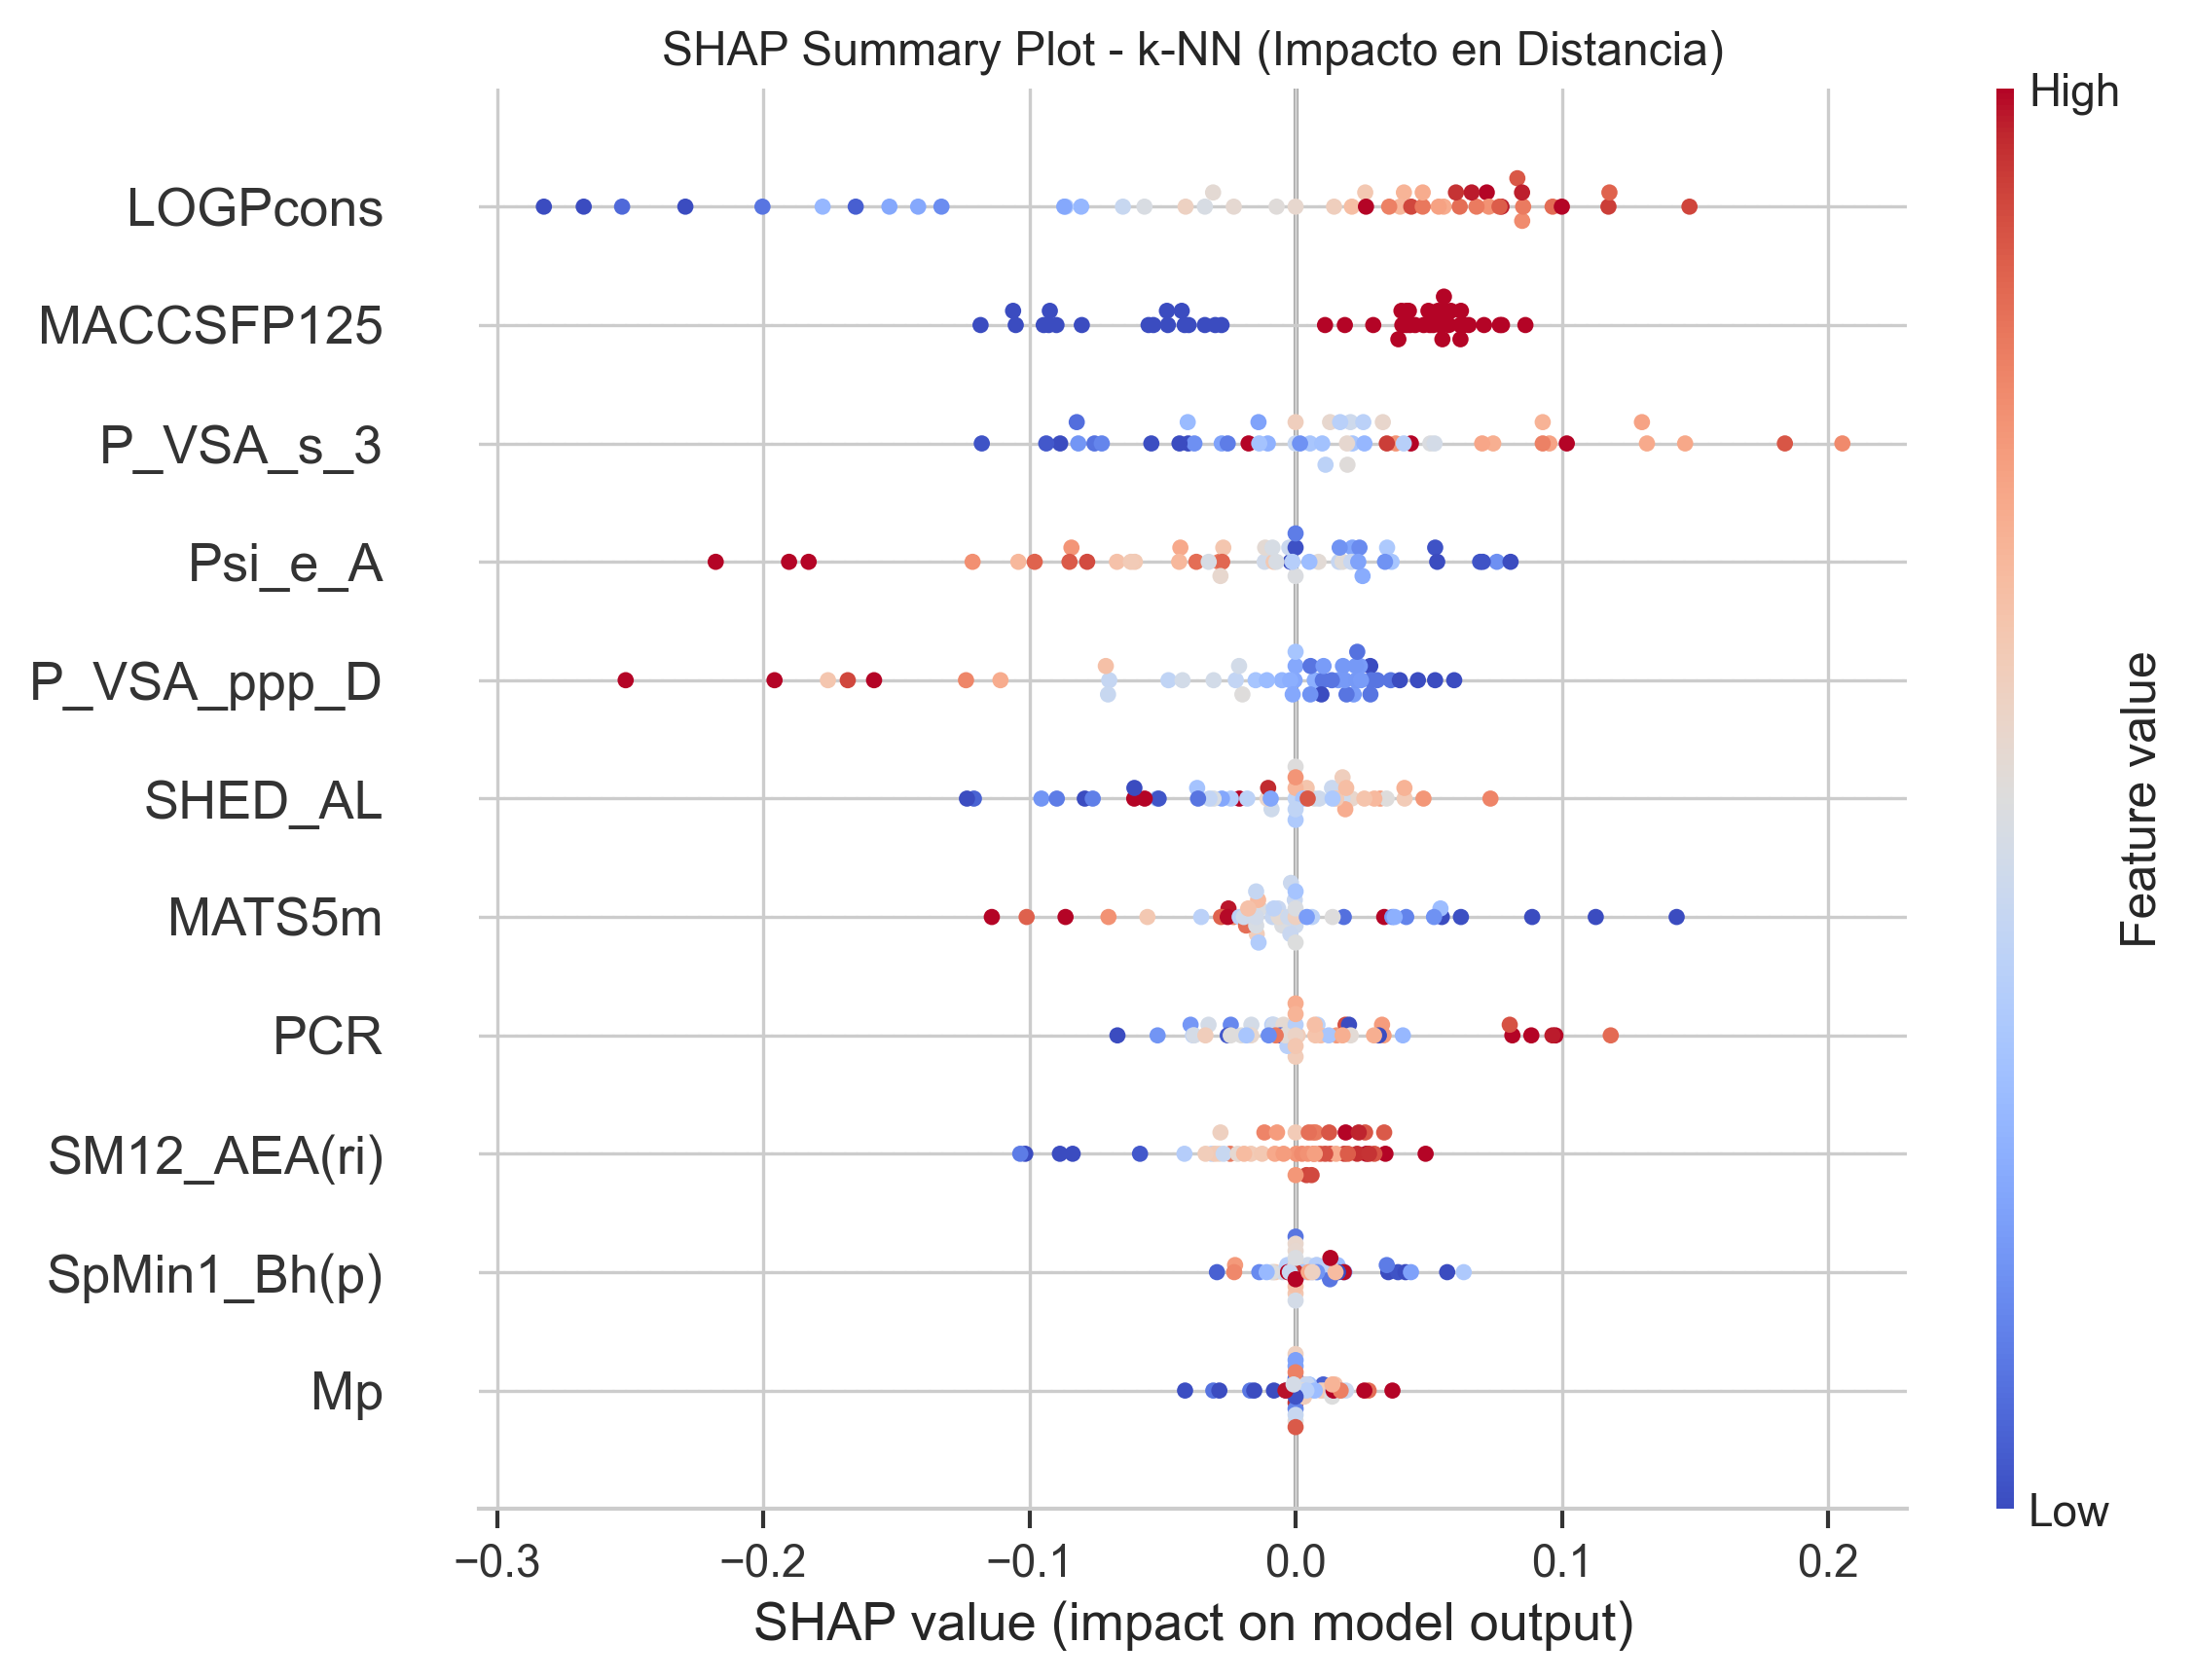

✅ Gráfico generado correctamente.


In [6]:
# 6. SHAP VALUES (KernelExplainer para k-NN) - CORREGIDO
# =============================================================================
print(" Calculando SHAP para k-NN (Aproximación por Kernel)...")

# 1. Preparar el Explainer
# Usamos kmeans para resumir el fondo (acelera el cálculo drásticamente)
# Convertimos a numpy para evitar problemas de índices con pandas
X_train_summary = shap.kmeans(X_train.values, 10)
explainer = shap.KernelExplainer(best_knn.predict_proba, X_train_summary)

# 2. Definir la muestra
# Tomamos 50 muestras para que sea rápido (Kernel es lento)
X_sample = X_test.sample(n=min(50, len(X_test)), random_state=42)

print(f"Calculando SHAP para {len(X_sample)} muestras...")
shap_values = explainer.shap_values(X_sample)

# 3. LÓGICA DE CORRECCIÓN DE DIMENSIONES (Debug)
vals_to_plot = None

# Caso A: Es una lista (común en clasificación binaria [Clase0, Clase1])
if isinstance(shap_values, list):
    print(f"Formato detectado: Lista de {len(shap_values)} arrays.")
    # Usamos la clase 1 (Activos)
    vals_to_plot = shap_values[1]

# Caso B: Es un array numpy
else:
    print(f"Formato detectado: Array con forma {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # (muestras, features, clases) -> Tomamos clase 1
        vals_to_plot = shap_values[:, :, 1]
    else:
        vals_to_plot = shap_values

# Verificación final de seguridad antes de graficar
print(f"Forma de los datos X: {X_sample.shape}")
print(f"Forma de SHAP values: {vals_to_plot.shape}")

if vals_to_plot.shape != X_sample.shape:
    print("⚠️ Ajustando dimensiones automáticamente...")
    # Si por alguna razón SHAP transpuso los datos o agregó una columna extra
    if vals_to_plot.shape[0] != X_sample.shape[0]:
        print("Error: El número de muestras no coincide.")
    elif vals_to_plot.shape[1] != X_sample.shape[1]:
        # A veces KernelExplainer agrega una columna constante al final, la quitamos
        vals_to_plot = vals_to_plot[:, :X_sample.shape[1]]

# 4. Graficar
try:
    plt.figure()
    plt.title("SHAP Summary Plot - k-NN (Impacto en Distancia)")
    shap.summary_plot(vals_to_plot, X_sample, show=False, cmap='coolwarm')
    plt.show()
    print("✅ Gráfico generado correctamente.")
except Exception as e:
    print(f" No se pudo generar el gráfico SHAP: {e}")

## Dominio de aplicabilidad 

 Evaluando Dominio de Aplicabilidad...


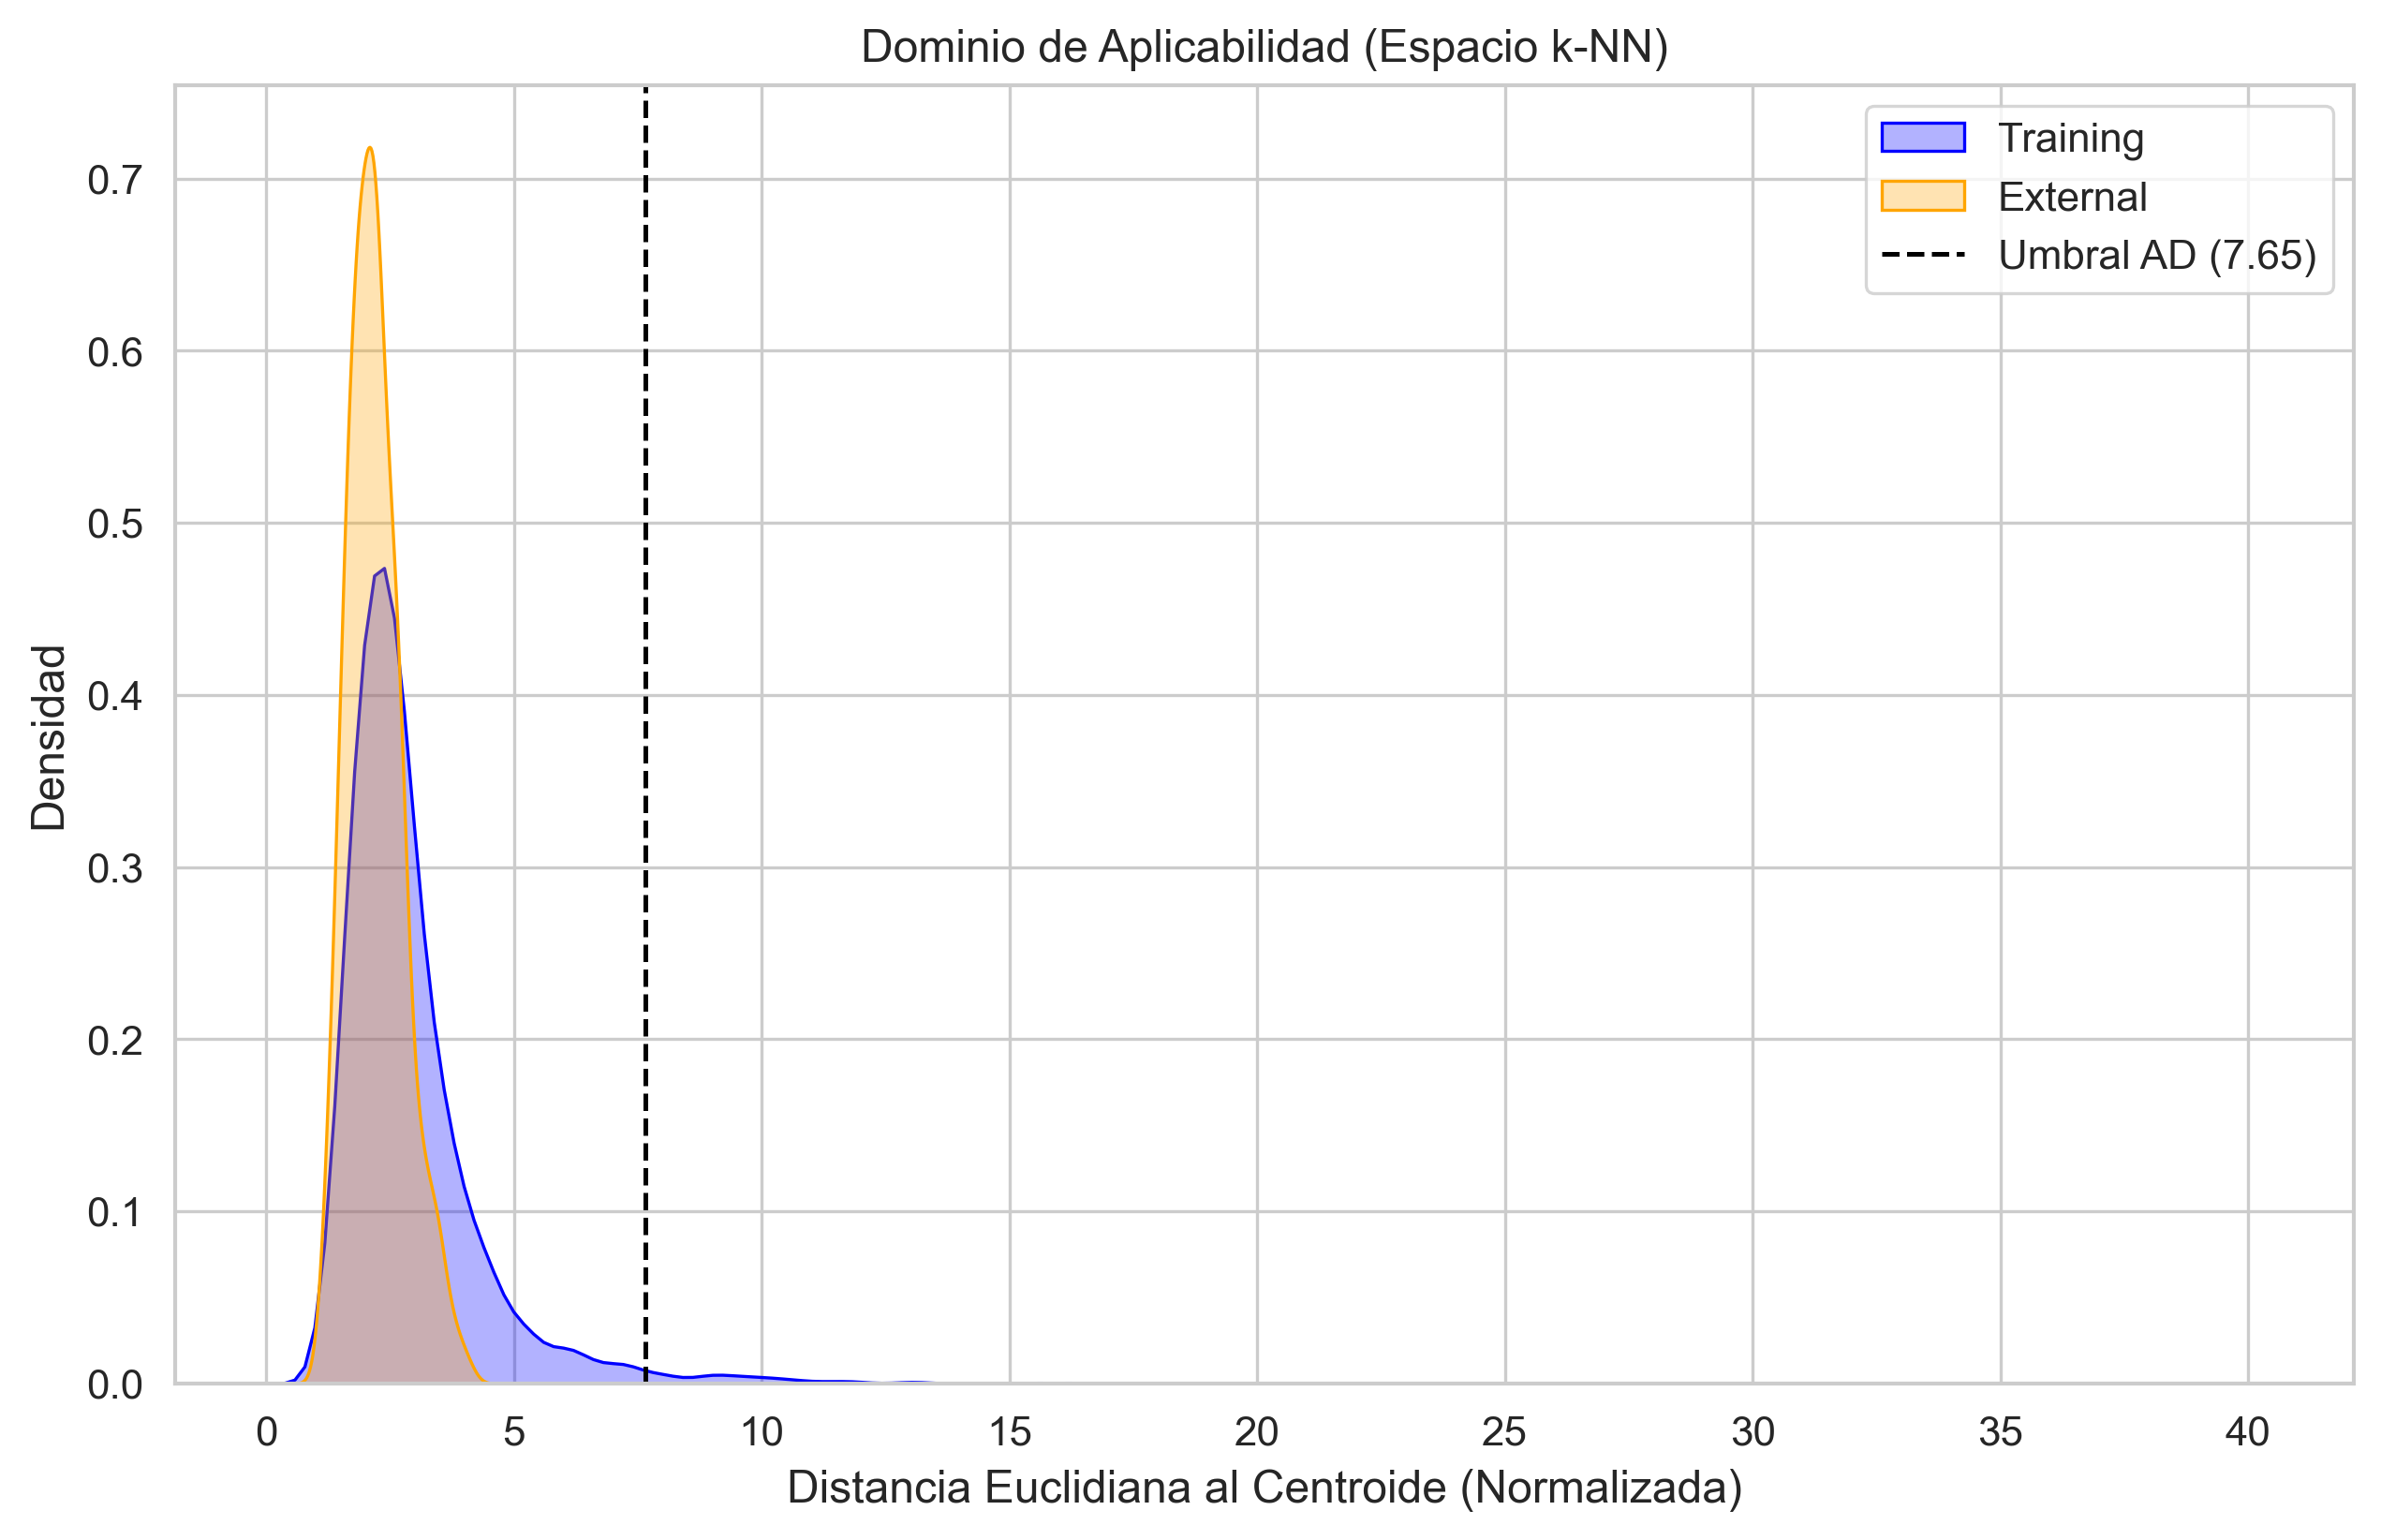

 Compuestos externos fuera del dominio: 0 de 486 (0.0%)


In [7]:
# 7. DOMINIO DE APLICABILIDAD (Distancia Nativa) - CORREGIDO
# =============================================================================
print(" Evaluando Dominio de Aplicabilidad...")

# CORRECCIÓN: Usamos .values para asegurar que trabajamos con arrays de NumPy
# X_train es un DataFrame, al sacar la media se vuelve Series. 
# .values lo convierte a array para poder usar .reshape
centroid = X_train.mean(axis=0).values.reshape(1, -1)

# Calcular distancias usando cdist (que espera arrays)
dist_train = cdist(X_train.values, centroid, 'euclidean')
dist_ext = cdist(X_ext.values, centroid, 'euclidean')

# Umbral estadístico (Media + 3 Desviaciones Estándar)
limit_ad = np.mean(dist_train) + 3 * np.std(dist_train)

# Gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(dist_train.flatten(), fill=True, color='blue', label='Training', alpha=0.3)
sns.kdeplot(dist_ext.flatten(), fill=True, color='orange', label='External', alpha=0.3)
plt.axvline(limit_ad, color='black', linestyle='--', label=f'Umbral AD ({limit_ad:.2f})')
plt.xlabel('Distancia Euclidiana al Centroide (Normalizada)')
plt.ylabel('Densidad')
plt.title('Dominio de Aplicabilidad (Espacio k-NN)')
plt.legend()
plt.show()

# Conteo de compuestos fuera del dominio
n_out = np.sum(dist_ext > limit_ad)
print(f" Compuestos externos fuera del dominio: {n_out} de {len(dist_ext)} ({n_out/len(dist_ext)*100:.1f}%)")